In [14]:
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pingouin as pg
np.warnings.filterwarnings('ignore')
%matplotlib inline

# ------------------------
# some helper functions
# ------------------------
def compute_ps(run1, run2):
    """
    run1 and run2 are two lists, each is a list of 4 epochs 
    """
    ps = []
    for epoch in run1:
        ps.append(np.mean([np.arctanh(pearsonr(epoch, y)[0]) for y in run2]))
    ps_mean = np.mean(ps)
    return(ps_mean)


def _separate_epochs(activity_data, epoch_list):
    """ create data epoch by epoch

    Separate data into conditions of interest specified in epoch_list

    Parameters
    ----------
    activity_data: list of 2D array in shape [nVoxels, nTRs]
        the masked activity data organized in voxel*TR formats of all subjects
    epoch_list: list of 3D array in shape [condition, nEpochs, nTRs]
        specification of epochs and conditions
        assuming all subjects have the same number of epochs
        len(epoch_list) equals the number of subjects

    Returns
    -------
    raw_data: list of 2D array in shape [nParcels, timepoints (36*16)]
        the data organized in epochs
        len(raw_data) equals 48 (24 subjects, 2 conditions for each subject for retrieve vs. perceive. )
    labels: list of 1D array
        the condition labels of the epochs
        len(labels) labels equals the number of epochs
    """
    raw_data = []
    labels = []
    for sid in range(len(epoch_list)): #for a given subject
        epoch = epoch_list[sid] # get their npy array
        for cond in range(epoch.shape[0]): # for a given condition
            # for each condition
            sub_epoch = epoch[cond, :, :]
            ts = np.zeros(1956)
            for eid in range(epoch.shape[1]):
                r = np.sum(sub_epoch[eid, :])
                if r > 0:   # there is an epoch in this condition
                    # collapse all epoch of a condition to a single time series
                    ts[sub_epoch[eid, :] == 1] = 1
            ts = ts.astype(np.bool)
            mat_cond = activity_data[sid][:,ts]
            mat_cond = np.ascontiguousarray(mat_cond)
            raw_data.append(mat_cond)
            labels.append(cond)

    return raw_data, labels

def divide_into_epoch(ts, epoch_length): 
    # looping till length l 
    for i in range(0, len(ts), epoch_length):  
        yield ts[i:i + epoch_length] 


### Background FC pattern analyses on Cognitive States (Perception vs. Retrieval; Figure 5)

In [5]:
bg_ts = []
base_dir = '../data/cluster_residual_activity'
bg_ts_dir = sorted(glob.glob(os.path.join(base_dir, "*")), key = lambda x: int(x.split('_')[-7]))[0:16]

# epoch files:
ret_per_epoch_list = np.load('../data/epoch_files/perceive_retrieve_epoch_labels.npy')
scramble_ret_epoch_list = np.load('../data/epoch_files/scramble_retrieve_epoch_labels.npy')
scramble_per_epoch_list = np.load('../data/epoch_files/scramble_perceive_epoch_labels.npy')

# list of 2d arrays, each for a cluster. 
ret_subClusterTR, per_subClusterTR, scramble_subClusterTR = [],[],[]


# ------------------------------------------------------------------------
# Preprocess data to get bg ts for each subject, condition, epoch, cluster
# ------------------------------------------------------------------------
        
for file in bg_ts_dir:
    cluster_subVoxTR = np.load(file)
    # preprocess the data;
    
    # ret vs. per
    raw_data_ret_per, labels_ret_per = _separate_epochs(cluster_subVoxTR, ret_per_epoch_list)
    raw_data_ret_per_mean = [np.mean(x, axis = 0) for x in raw_data_ret_per] # average within ROI
    raw_data_ret_mean = [raw_data_ret_per_mean[cond] for cond in np.where(np.array(labels_ret_per) == 0)[0].tolist()] # ret bg ts
    raw_data_per_mean = [raw_data_ret_per_mean[cond] for cond in np.where(np.array(labels_ret_per) == 1)[0].tolist()] # per bg ts
    
    # scramble vs. ret
    raw_data_scramble_ret, labels_scramble_ret = _separate_epochs(cluster_subVoxTR, scramble_ret_epoch_list)
    raw_data_scramble_ret_mean = [np.mean(x, axis = 0) for x in raw_data_scramble_ret] # average within ROI
    raw_data_scramble_mean = [raw_data_scramble_ret_mean[cond] for cond in np.where(np.array(labels_scramble_ret) == 0)[0].tolist()] # scramble bg ts
    raw_data_ret_mean2 = [raw_data_scramble_ret_mean[cond] for cond in np.where(np.array(labels_scramble_ret) == 1)[0].tolist()] # ret bg ts
    
    # scramble vs. per
    raw_data_scramble_per, labels_scramble_per = _separate_epochs(cluster_subVoxTR, scramble_per_epoch_list)
    raw_data_scramble_per_mean = [np.mean(x, axis = 0) for x in raw_data_scramble_per] # average within ROI
    raw_data_scramble_mean2 = [raw_data_scramble_per_mean[cond] for cond in np.where(np.array(labels_scramble_per) == 0)[0].tolist()] # scramble bg ts
    raw_data_per_mean2 = [raw_data_scramble_per_mean[cond] for cond in np.where(np.array(labels_scramble_per) == 1)[0].tolist()] # per bg ts
    
    # make sure the duplicated ts are all the same (sanity check)
    check_ret = np.unique([(x == y).all() for x,y in zip(raw_data_ret_mean,raw_data_ret_mean2)])
    check_per = np.unique([(x == y).all() for x,y in zip(raw_data_per_mean,raw_data_per_mean2)])
    check_scramble = np.unique([(x == y).all() for x,y in zip(raw_data_scramble_mean,raw_data_scramble_mean2)])
    
    if check_ret & check_per & check_scramble != True:
        print("Something is wrong")
        break
    
    # devide into ret epoch 
    ret_epoch_ts = []
    per_epoch_ts = []
    scramble_epoch_ts = []
    for sub in range(len(raw_data_ret_mean)): # for each subject
        ret_epoch_ts.append(np.stack(list(divide_into_epoch(raw_data_ret_mean[sub], 36)), axis = 0))
        per_epoch_ts.append(np.stack(list(divide_into_epoch(raw_data_per_mean[sub], 36)), axis = 0))
        scramble_epoch_ts.append(np.stack(list(divide_into_epoch(raw_data_scramble_mean[sub], 36)), axis = 0))
    
    # for a given cluster
    ret_epoch_ts_np = np.stack(ret_epoch_ts, axis = 0)  #(24sub, 16epoch, 36tr)
    per_epoch_ts_np = np.stack(per_epoch_ts, axis = 0)  #(24sub, 16epoch, 36tr)
    scramble_epoch_ts_np = np.stack(scramble_epoch_ts, axis = 0)  #(24sub, 16epoch, 36tr)
      
    # for in a total of 16 clusters    
    ret_subClusterTR.append(ret_epoch_ts_np)
    per_subClusterTR.append(per_epoch_ts_np)
    scramble_subClusterTR.append(scramble_epoch_ts_np)
    
# here the shapes are: (24sub, 16epoch, 16Clusters, 36tr)
ret_subClusterTR_4d = np.stack(ret_subClusterTR, axis = 2)
per_subClusterTR_4d = np.stack(per_subClusterTR, axis = 2)
scramble_subClusterTR_4d = np.stack(scramble_subClusterTR, axis = 2)

# ----------------------------------------
# Compute correlation matrices of needed
# ----------------------------------------

# this will be come 24 (subjects) 16 by 16 corMat
ret_corMat_persub = []
per_corMat_persub = []
scramble_corMat_persub = []
for sub in range(24): 
    # for each subject
    ret_cluster_epoch_cluster_tr = ret_subClusterTR_4d[sub, :,:,:]
    per_cluster_epoch_cluster_tr = per_subClusterTR_4d[sub, :,:,:]
    scramble_cluster_epoch_cluster_tr = scramble_subClusterTR_4d[sub, :,:,:]
    # for each epoch
    ret_sub_cormat = [np.corrcoef(ret_cluster_epoch_cluster_tr[epoch, :, :]) for epoch in range(16)] # compute cluster x cluster (16x16) cormat for each subject retrieve epoch
    per_sub_cormat = [np.corrcoef(per_cluster_epoch_cluster_tr[epoch, :, :]) for epoch in range(16)] # compute cluster x cluster (16x16) cormat for each subject perceive epoch
    scramble_sub_cormat = [np.corrcoef(scramble_cluster_epoch_cluster_tr[epoch, :, :]) for epoch in range(16)] # compute cluster x cluster (16x16) cormat for each subject scramble epoch
    
    # do this for each subject
    ret_corMat_persub.append(ret_sub_cormat) # 24(subject) x 16(epoch) x 16x16 (cormat) for ret
    per_corMat_persub.append(per_sub_cormat) # 24(subject) x 16(epoch) x 16x16 (cormat) for per
    scramble_corMat_persub.append(scramble_sub_cormat) # 24(subject) x 16(epoch) x 16x16 (cormat) for scramble

cond_sub_cormat = np.concatenate([ret_corMat_persub, per_corMat_persub, scramble_corMat_persub], axis = 1 ) # 24 (subjects) x 48 (epochs) x cormat
epoch_id = ['Retrieve', 'Retrieve', 'Perceive', 'Perceive', 'Scramble', 'Scramble']

within_state_ps_per_sub_per_ROI = []
between_state_ps_per_sub_per_ROI = []
for sub in list(range(24)): # for every subject
    #within_state_ps_per_ROI = []
    #between_state_ps_per_ROI = []
    for cluster in list(range(16)): # for each cluster
    
        sub_cluster_epoch = {}
        for idx, e_id in enumerate(epoch_id):

            if idx%2 == 0: # if even
                sub_cluster_epoch[f'{e_id}_run1'] = cond_sub_cormat[sub, idx*8:idx*8+8, cluster, :] # 1 (sub) x 8 (epoch/run) x 1 (this cluster) x 16 (rest cluster)
            else: # if odd 
                sub_cluster_epoch[f'{e_id}_run2'] = cond_sub_cormat[sub, idx*8:idx*8+8, cluster, :] 

        # account for existing inbalance.  
        within_state_ps_per_sub_per_ROI.append(np.mean([compute_ps(sub_cluster_epoch['Retrieve_run1'],sub_cluster_epoch['Retrieve_run2']),
                                                compute_ps(sub_cluster_epoch['Perceive_run1'],sub_cluster_epoch['Perceive_run2']),
                                                compute_ps(sub_cluster_epoch['Scramble_run1'],sub_cluster_epoch['Scramble_run2']),
                                                np.mean([compute_ps(sub_cluster_epoch['Perceive_run1'],sub_cluster_epoch['Scramble_run1']),
                                                compute_ps(sub_cluster_epoch['Perceive_run1'],sub_cluster_epoch['Scramble_run2']),
                                                compute_ps(sub_cluster_epoch['Perceive_run2'],sub_cluster_epoch['Scramble_run1']),
                                                compute_ps(sub_cluster_epoch['Perceive_run2'],sub_cluster_epoch['Scramble_run2'])])]))
                                                
        between_state_ps_per_sub_per_ROI.append(np.mean([compute_ps(sub_cluster_epoch['Retrieve_run1'],sub_cluster_epoch['Perceive_run1']),
                                                compute_ps(sub_cluster_epoch['Retrieve_run1'],sub_cluster_epoch['Perceive_run2']),
                                                compute_ps(sub_cluster_epoch['Retrieve_run1'],sub_cluster_epoch['Scramble_run1']),
                                                compute_ps(sub_cluster_epoch['Retrieve_run1'],sub_cluster_epoch['Scramble_run2']),
                                                compute_ps(sub_cluster_epoch['Retrieve_run2'],sub_cluster_epoch['Perceive_run1']),
                                                compute_ps(sub_cluster_epoch['Retrieve_run2'],sub_cluster_epoch['Perceive_run2']),
                                                compute_ps(sub_cluster_epoch['Retrieve_run2'],sub_cluster_epoch['Scramble_run1']),
                                                compute_ps(sub_cluster_epoch['Retrieve_run2'],sub_cluster_epoch['Scramble_run2'])]))



In [6]:
# ----------------------------
# Write CSV and save the data
# ----------------------------
roi = ["mPFC","rAG","Precuneus(inferior)","lLOC","rLOC","Precuneus(Superior)","lAG1","rPFC","lPFC1","PCC",
       "Precuenus(Inferior)2","SFG","lPFC2","MTG","lAG2","rITG"]
roi_other_name = ["mPFC", "r-IPL", "RSC1", "l-IPS", "r-IPS", "PCUN", "l-IPL1", "r-PFC", "l-PFC1", "PCC",
                  "RSC2", "SFG", 'l-PFC2', "MTG", "l-IPL2", "r-ITG"]
roi_type = ['DMN','DMN','RSC','CONT','CONT','DMN','DMN','CONT','CONT','DMN','RSC','CONT','CONT',
            'DMN','DMN','CONT']
df = pd.DataFrame(columns = ['sub_id','within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.repeat(range(1,25),16).tolist() 
#df['within_state_ps'] = list(itertools.chain(*within_state_ps_per_sub_per_ROI))
df['within_state_ps'] = within_state_ps_per_sub_per_ROI
#df['between_state_ps'] = list(itertools.chain(*between_state_ps_per_sub_per_ROI))
df['between_state_ps'] = between_state_ps_per_sub_per_ROI
df['cluster'] = np.tile(roi_other_name, 24)
df['cluster_type'] = np.tile(roi_type, 24)
df['cogState_index'] =  df['within_state_ps'] - df['between_state_ps']

df_cogState = df.copy(deep = True)
df_cogState.to_csv('patternSimilarity_results/bgFC_cogState_idx.csv', index = False)

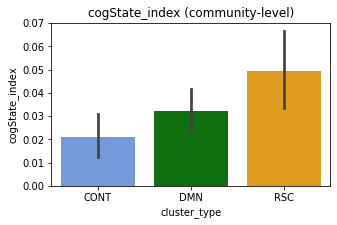

In [26]:
# ----------------------
# Community level plot 
# ----------------------
df_cogState = df_cogState.groupby(['cluster_type', 'sub_id']).mean().reset_index()

fig = plt.figure(figsize = (5, 3))
sns.barplot(x="cluster_type", y="cogState_index", order = ['CONT', 'DMN', 'RSC'],
            palette=["cornflowerblue", "green", "orange"], data=df_cogState).set_title('cogState_index (community-level)')
plt.show()

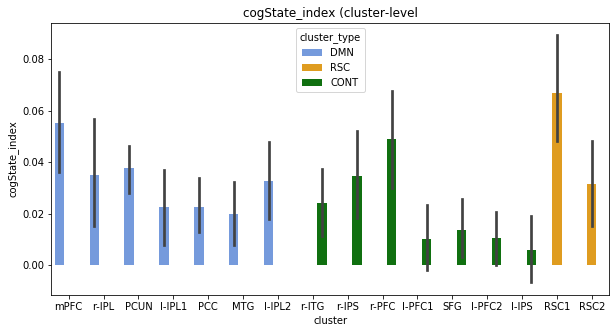

In [27]:
# --------------------
# Cluster level plot 
# --------------------
order = ["mPFC", "r-IPL", "PCUN", "l-IPL1", "PCC", "MTG", "l-IPL2", "r-ITG", "r-IPS", "r-PFC",
                  "l-PFC1", "SFG", 'l-PFC2', "l-IPS", "RSC1", "RSC2"]

fig = plt.figure(figsize = (10, 5))
sns.barplot(x="cluster", y="cogState_index", hue='cluster_type', order = order,
            palette=["cornflowerblue", "orange", "green"], data=df).set_title('cogState_index (cluster-level')
plt.show()

In [60]:
df_cogState_net = df_cogState.groupby(['sub_id', 'cluster_type']).mean().reset_index()
print("----cognitve state distinction fc anova-----")
pg.rm_anova(df_cogState_net, dv = "cogState_index", within = ['cluster_type'], subject="sub_id")

----cognitve state distinction fc anova-----


,Source,ddof1,ddof2,F,p-unc,np2,eps
0,cluster_type,2,46,6.3195,0.00376,0.215539,0.726624


In [24]:
print("----cognitive state fc index, RSC vs. DMN")
pg.ttest(df_cogState_net.loc[df_cogState_net['cluster_type'] == "RSC", "cogState_index"].tolist(),
df_cogState_net.loc[df_cogState_net['cluster_type'] == "DMN", "cogState_index"].tolist(), paired = True)

----cognitive state fc index, RSC vs. DMN


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.94567,23,two-sided,0.064016,"[-0.0, 0.04]",0.485707,1.072,0.625291


In [23]:
print("----cognitive state fc index, RSC vs. Cont network")
pg.ttest(df_cogState_net.loc[df_cogState_net['cluster_type'] == "RSC", "cogState_index"].tolist(),
df_cogState_net.loc[df_cogState_net['cluster_type'] == "CONT", "cogState_index"].tolist(), paired = True)

----cognitive state fc index, RSC vs. Cont network


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.982161,23,two-sided,0.006663,"[0.01, 0.05]",0.784774,6.821,0.957254


### Background FC pattern analyses on Behavioral-task distinction (Male/Female vs. Natural/Manmade task)

In [34]:
# load in epoch file
epoch_file = '../data/epoch_files/faceTask_sceneTask_epoch_lables_48epochs_fc.npy'
base_dir = '../data/cluster_residual_activity'
bg_ts_dir = sorted(glob.glob(os.path.join(base_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# list of 2d arrays, each for a cluster. 
face_subClusterTR, scene_subClusterTR = [],[]

# ------------------------------------------------------------------------
# Preprocess data to get bg ts for each subject, condition, epoch, cluster
# ------------------------------------------------------------------------
        
for file in bg_ts_dir:
    cluster_subVoxTR = np.load(file) # for each cluster
    
    # load epoch info 
    raw_data_face_scene, labels_face_scene = _separate_epochs(cluster_subVoxTR, np.load(epoch_file)) # (48 (24subx2cond), nVoxel, 576 (24epoch/condx24tr))
    raw_data_face_scene_mean = [np.mean(x, axis = 0) for x in raw_data_face_scene] # [48, 576]
    raw_data_face_mean = [raw_data_face_scene_mean[cond] for cond in np.where(np.array(labels_face_scene) == 0)[0].tolist()] # FACE bg ts (24, 576)
    raw_data_scene_mean = [raw_data_face_scene_mean[cond] for cond in np.where(np.array(labels_face_scene) == 1)[0].tolist()] # scene bg ts (24, 576)

    # devide into ret epoch 
    face_epoch_ts = []
    scene_epoch_ts = []
    for sub in range(len(raw_data_face_mean)): # for each subject
        face_epoch_ts.append(np.stack(list(divide_into_epoch(raw_data_face_mean[sub], 24)), axis = 0))
        scene_epoch_ts.append(np.stack(list(divide_into_epoch(raw_data_scene_mean[sub], 24)), axis = 0))
    
    # Stack epcohs for each condition 
    face_epoch_ts_np = np.stack(face_epoch_ts, axis = 0)  #(24sub, 24epoch, 24tr)
    scene_epoch_ts_np = np.stack(scene_epoch_ts, axis = 0)  #(24sub, 24epoch, 24tr)
      
    # for in a total of 16 clusters    
    face_subClusterTR.append(face_epoch_ts_np)
    scene_subClusterTR.append(scene_epoch_ts_np) # (16cluster, 24sub, 24epochs 24tr)

# here the shapes are: (24sub, 24epoch, 16Clusters, 24tr) face/scene conditions, thus each condition has 24 epochs
face_subClusterTR_4d = np.stack(face_subClusterTR, axis = 2)
scene_subClusterTR_4d = np.stack(scene_subClusterTR, axis = 2)


# ----------------------------------------
# Compute correlation matrices of needed
# ----------------------------------------
# this will be come 24 (subjects) 16 by 16 corMat for each epoch
face_corMat_persub = []
scene_corMat_persub = []
for sub in range(24): 
    # for each subject
    face_epoch_cluster_tr = face_subClusterTR_4d[sub, :,:,:]
    scene_epoch_cluster_tr = scene_subClusterTR_4d[sub, :,:,:]
    
    # for each epoch
    face_sub_cormat = [np.corrcoef(face_epoch_cluster_tr[epoch, :, :]) for epoch in range(24)] # compute cluster x cluster (16x16) cormat for each subject face epoch
    scene_sub_cormat = [np.corrcoef(scene_epoch_cluster_tr[epoch, :, :]) for epoch in range(24)] # compute cluster x cluster (16x16) cormat for each subject scene epoch
  
    # do this for each subject
    face_corMat_persub.append(face_sub_cormat) # 24(subject) x 24(epoch) x 16x16 (cormat) for face
    scene_corMat_persub.append(scene_sub_cormat) # 24(subject) x 24(epoch) x 16x16 (cormat) for scene

face_corMat_persub_np = np.stack(face_corMat_persub, axis = 0)
scene_corMat_persub_np = np.stack(scene_corMat_persub, axis = 0)
# -------------------------------------------------------------
# Get epoch identity (Attention condition for each task epoch)
# -------------------------------------------------------------

# get epoch identity (i.e., face/scene task under which condition )
epoch_identity = pd.read_csv('../data/epoch_files/block_image_identity.csv')
faceTask_cond = epoch_identity.loc[epoch_identity['block'] == 'Face', 'condition'].tolist()
sceneTask_cond = epoch_identity.loc[epoch_identity['block'] == 'Scene', 'condition'].tolist()
# epoch_id obtained from faceTask_cond should be identical to those obtained from sceneTask_cond
epoch_id = [np.unique(faceTask_cond[start:start+4])[0] for start in list(np.arange(0,576,4))] # 6runs x 24 subjects 
#epoch_id = [np.unique(sceneTask_cond[start:start+4])[0] for start in list(np.arange(0,576,4))] # 6runs x 24 subjects 


within_state_ps_per_sub_per_ROI = []
between_state_ps_per_sub_per_ROI = []
for sub in list(range(24)): # for every subject
    #within_state_ps_per_ROI = []
    #between_state_ps_per_ROI = []
    epoch_id_sub = epoch_id[6*sub: 6*sub+6]
    for cluster in list(range(16)): # for each cluster
    
        face,scene = {},{}
        for idx, e_id in enumerate(epoch_id_sub):

            if idx < 3: # if run1
                face[f'{e_id}_run1_face'] = face_corMat_persub_np[sub, idx*4:idx*4+4, cluster, :] # 1 (sub) x 4 (epoch/run) x 1 (this cluster) x 16 (rest cluster)
                scene[f'{e_id}_run1_scene'] = scene_corMat_persub_np[sub, idx*4:idx*4+4, cluster, :] # 1 (sub) x 4 (epoch/run) x 1 (this cluster) x 16 (rest cluster)
            else: # if run2
                face[f'{e_id}_run2_face'] = face_corMat_persub_np[sub, idx*4:idx*4+4, cluster, :] # 1 (sub) x 4 (epoch/run) x 1 (this cluster) x 16 (rest cluster)
                scene[f'{e_id}_run2_scene'] = scene_corMat_persub_np[sub, idx*4:idx*4+4, cluster, :] # 1 (sub) x 4 (epoch/run) x 1 (this cluster) x 16 (rest cluster)
        
        within_state_ps_per_sub_per_ROI.append(np.mean([np.mean([compute_ps(face['Perceive_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['Retrieve_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['Retrieve_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['PerceiveScrambled_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['PerceiveScrambled_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run2_scene'])]),
                                       np.mean([compute_ps(face['Perceive_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run2_scene'])])]))
        # compute between- state PS
        between_state_ps_per_sub_per_ROI.append(np.mean([np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run2_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run2_face']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['PerceiveScrambled_run2_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(face['Retrieve_run1_face'], scene['Retrieve_run2_scene'])]),
                                                np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['Perceive_run2_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['Perceive_run2_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run2_face'])])]))


In [43]:
# ----------------------------
# Write CSV and save the data
# ----------------------------
roi = ["mPFC","rAG","Precuneus(inferior)","lLOC","rLOC","Precuneus(Superior)","lAG1","rPFC","lPFC1","PCC",
       "Precuenus(Inferior)2","SFG","lPFC2","MTG","lAG2","rITG"]
roi_other_name = ["mPFC", "r-IPL", "RSC1", "l-IPS", "r-IPS", "PCUN", "l-IPL1", "r-PFC", "l-PFC1", "PCC",
                  "RSC2", "SFG", 'l-PFC2', "MTG", "l-IPL2", "r-ITG"]
roi_type = ['DMN','DMN','RSC','CONT','CONT','DMN','DMN','CONT','CONT','DMN','RSC','CONT','CONT',
            'DMN','DMN','CONT']
df = pd.DataFrame(columns = ['sub_id','within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.repeat(range(1,25),16).tolist() 
#df['within_state_ps'] = list(itertools.chain(*within_state_ps_per_sub_per_ROI))
df['within_state_ps'] = within_state_ps_per_sub_per_ROI
#df['between_state_ps'] = list(itertools.chain(*between_state_ps_per_sub_per_ROI))
df['between_state_ps'] = between_state_ps_per_sub_per_ROI
df['cluster'] = np.tile(roi_other_name, 24)
df['cluster_type'] = np.tile(roi_type, 24)
df['task_index'] =  df['within_state_ps'] - df['between_state_ps']

df_taskState = df.copy(deep = True)
df_taskState.to_csv('patternSimilarity_results/bgFC_taskState_idx.csv', index = False)

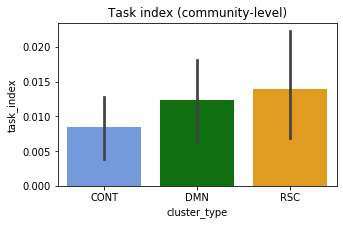

In [47]:
# --------------------
# Community level plot 
# --------------------
df = df_taskState.groupby(['cluster_type', 'sub_id']).mean().reset_index()
#AnovaRM(data=ps_attention, depvar='attention_index', subject='sub_id', within=['cluster_type']).fit())

fig = plt.figure(figsize = (5, 3))
sns.barplot(x="cluster_type", y="task_index", order = ['CONT','DMN','RSC'],
            palette=["cornflowerblue", "green", "orange"], data=df).set_title('Task index (community-level)')
plt.show()

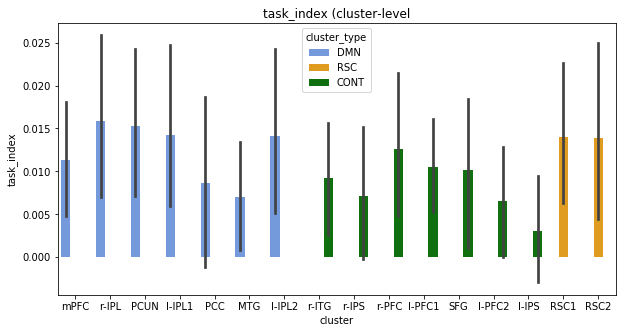

In [48]:
# --------------------
# Cluster level plot 
# --------------------
order = ["mPFC", "r-IPL", "PCUN", "l-IPL1", "PCC", "MTG", "l-IPL2", "r-ITG", "r-IPS", "r-PFC",
                  "l-PFC1", "SFG", 'l-PFC2', "l-IPS", "RSC1", "RSC2"]

fig = plt.figure(figsize = (10, 5))
sns.barplot(x="cluster", y="task_index", hue='cluster_type', order = order,
            palette=["cornflowerblue", "orange", "green"], data=df_taskState).set_title('task_index (cluster-level')
plt.show()

In [59]:
df_taskState_net = df_taskState.groupby(['sub_id', 'cluster_type']).mean().reset_index()
print("----Behavioral task distinction fc anova-----")
pg.rm_anova(df_taskState_net, dv = "task_index", within = ['cluster_type'], subject="sub_id")

----Behavioral task distinction fc anova-----


,Source,ddof1,ddof2,F,p-unc,np2,eps
0,cluster_type,2,46,1.081533,0.34754,0.044911,0.727325


### Background FC pattern analyses on Visual content distinction (Face vs. Scene)

In [51]:
# load in epoch file
epoch_file = '../data/epoch_files/faceCue_sceneCue_epoch_lables_48epochs_fc.npy'
base_dir = '../data/cluster_residual_activity'
bg_ts_dir = sorted(glob.glob(os.path.join(base_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# list of 2d arrays, each for a cluster. 
face_subClusterTR, scene_subClusterTR = [],[]

# ------------------------------------------------------------------------
# Preprocess data to get bg ts for each subject, condition, epoch, cluster
# ------------------------------------------------------------------------
        
for file in bg_ts_dir:
    cluster_subVoxTR = np.load(file) # for each cluster
    
    # load epoch info 
    raw_data_face_scene, labels_face_scene = _separate_epochs(cluster_subVoxTR, np.load(epoch_file)) # (48 (24subx2cond), nVoxel, 576 (24epoch/condx24tr))
    raw_data_face_scene_mean = [np.mean(x, axis = 0) for x in raw_data_face_scene] # [48, 576]
    raw_data_face_mean = [raw_data_face_scene_mean[cond] for cond in np.where(np.array(labels_face_scene) == 0)[0].tolist()] # FACE bg ts (24, 576)
    raw_data_scene_mean = [raw_data_face_scene_mean[cond] for cond in np.where(np.array(labels_face_scene) == 1)[0].tolist()] # scene bg ts (24, 576)

    # devide into ret epoch 
    face_epoch_ts = []
    scene_epoch_ts = []
    for sub in range(len(raw_data_face_mean)): # for each subject
        face_epoch_ts.append(np.stack(list(divide_into_epoch(raw_data_face_mean[sub], 24)), axis = 0))
        scene_epoch_ts.append(np.stack(list(divide_into_epoch(raw_data_scene_mean[sub], 24)), axis = 0))
    
    # Stack epcohs for each condition 
    face_epoch_ts_np = np.stack(face_epoch_ts, axis = 0)  #(24sub, 24epoch, 24tr)
    scene_epoch_ts_np = np.stack(scene_epoch_ts, axis = 0)  #(24sub, 24epoch, 24tr)
      
    # for in a total of 16 clusters    
    face_subClusterTR.append(face_epoch_ts_np)
    scene_subClusterTR.append(scene_epoch_ts_np) # (16cluster, 24sub, 24epochs 24tr)

# here the shapes are: (24sub, 24epoch, 16Clusters, 24tr) face/scene conditions, thus each condition has 24 epochs
face_subClusterTR_4d = np.stack(face_subClusterTR, axis = 2)
scene_subClusterTR_4d = np.stack(scene_subClusterTR, axis = 2)


# ----------------------------------------
# Compute correlation matrices of needed
# ----------------------------------------
# this will be come 24 (subjects) 16 by 16 corMat for each epoch
face_corMat_persub = []
scene_corMat_persub = []
for sub in range(24): 
    # for each subject
    face_epoch_cluster_tr = face_subClusterTR_4d[sub, :,:,:]
    scene_epoch_cluster_tr = scene_subClusterTR_4d[sub, :,:,:]
    
    # for each epoch
    face_sub_cormat = [np.corrcoef(face_epoch_cluster_tr[epoch, :, :]) for epoch in range(24)] # compute cluster x cluster (16x16) cormat for each subject face epoch
    scene_sub_cormat = [np.corrcoef(scene_epoch_cluster_tr[epoch, :, :]) for epoch in range(24)] # compute cluster x cluster (16x16) cormat for each subject scene epoch
  
    # do this for each subject
    face_corMat_persub.append(face_sub_cormat) # 24(subject) x 24(epoch) x 16x16 (cormat) for face
    scene_corMat_persub.append(scene_sub_cormat) # 24(subject) x 24(epoch) x 16x16 (cormat) for scene

face_corMat_persub_np = np.stack(face_corMat_persub, axis = 0)
scene_corMat_persub_np = np.stack(scene_corMat_persub, axis = 0)
# -------------------------------------------------------------
# Get epoch identity (Attention condition for each task epoch)
# -------------------------------------------------------------

# get epoch identity (i.e., face/scene task under which condition )
epoch_identity = pd.read_csv('../data/epoch_files/block_image_identity.csv')
faceTask_cond = epoch_identity.loc[epoch_identity['block'] == 'Face', 'condition'].tolist() # does not matter, we only need condition info 
sceneTask_cond = epoch_identity.loc[epoch_identity['block'] == 'Scene', 'condition'].tolist()
# epoch_id obtained from faceTask_cond should be identical to those obtained from sceneTask_cond
epoch_id = [np.unique(faceTask_cond[start:start+4])[0] for start in list(np.arange(0,576,4))] # 6runs x 24 subjects 
#epoch_id = [np.unique(sceneTask_cond[start:start+4])[0] for start in list(np.arange(0,576,4))] # 6runs x 24 subjects 


within_state_ps_per_sub_per_ROI = []
between_state_ps_per_sub_per_ROI = []
for sub in list(range(24)): # for every subject
    #within_state_ps_per_ROI = []
    #between_state_ps_per_ROI = []
    epoch_id_sub = epoch_id[6*sub: 6*sub+6]
    for cluster in list(range(16)): # for each cluster
    
        face,scene = {},{}
        for idx, e_id in enumerate(epoch_id_sub):

            if idx < 3: # if run1
                face[f'{e_id}_run1_face'] = face_corMat_persub_np[sub, idx*4:idx*4+4, cluster, :] # 1 (sub) x 4 (epoch/run) x 1 (this cluster) x 16 (rest cluster)
                scene[f'{e_id}_run1_scene'] = scene_corMat_persub_np[sub, idx*4:idx*4+4, cluster, :] # 1 (sub) x 4 (epoch/run) x 1 (this cluster) x 16 (rest cluster)
            else: # if run2
                face[f'{e_id}_run2_face'] = face_corMat_persub_np[sub, idx*4:idx*4+4, cluster, :] # 1 (sub) x 4 (epoch/run) x 1 (this cluster) x 16 (rest cluster)
                scene[f'{e_id}_run2_scene'] = scene_corMat_persub_np[sub, idx*4:idx*4+4, cluster, :] # 1 (sub) x 4 (epoch/run) x 1 (this cluster) x 16 (rest cluster)
        
        within_state_ps_per_sub_per_ROI.append(np.mean([np.mean([compute_ps(face['Perceive_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['Retrieve_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['Retrieve_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['PerceiveScrambled_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['PerceiveScrambled_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run2_scene'])]),
                                       np.mean([compute_ps(face['Perceive_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run2_scene'])])]))
        # compute between- state PS
        between_state_ps_per_sub_per_ROI.append(np.mean([np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run2_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run2_face']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['PerceiveScrambled_run2_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Perceive_run2_scene']),
                                                        compute_ps(face['Retrieve_run1_face'], scene['Retrieve_run2_scene'])]),
                                                np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['Perceive_run1_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(face['Perceive_run2_face'], scene['Retrieve_run1_scene']),
                                                        compute_ps(face['Perceive_run2_face'], scene['Retrieve_run2_scene']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run2_face']),
                                                        compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run1_face']),
                                                        compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run2_face'])])]))

In [54]:
# ----------------------------
# Write CSV and save the data
# ----------------------------
roi = ["mPFC","rAG","Precuneus(inferior)","lLOC","rLOC","Precuneus(Superior)","lAG1","rPFC","lPFC1","PCC",
       "Precuenus(Inferior)2","SFG","lPFC2","MTG","lAG2","rITG"]
roi_other_name = ["mPFC", "r-IPL", "RSC1", "l-IPS", "r-IPS", "PCUN", "l-IPL1", "r-PFC", "l-PFC1", "PCC",
                  "RSC2", "SFG", 'l-PFC2', "MTG", "l-IPL2", "r-ITG"]
roi_type = ['DMN','DMN','RSC','CONT','CONT','DMN','DMN','CONT','CONT','DMN','RSC','CONT','CONT',
            'DMN','DMN','CONT']
df = pd.DataFrame(columns = ['sub_id','within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.repeat(range(1,25),16).tolist() 
#df['within_state_ps'] = list(itertools.chain(*within_state_ps_per_sub_per_ROI))
df['within_state_ps'] = within_state_ps_per_sub_per_ROI
#df['between_state_ps'] = list(itertools.chain(*between_state_ps_per_sub_per_ROI))
df['between_state_ps'] = between_state_ps_per_sub_per_ROI
df['cluster'] = np.tile(roi_other_name, 24)
df['cluster_type'] = np.tile(roi_type, 24)
df['visual_index'] =  df['within_state_ps'] - df['between_state_ps']

df_visState = df.copy(deep = True)
df_visState.to_csv('patternSimilarity_results/bgFC_visState_idx.csv')

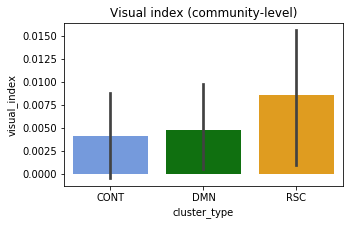

In [55]:
# --------------------
# Community level plot 
# --------------------
df = df_visState.groupby(['cluster_type', 'sub_id']).mean().reset_index()
#AnovaRM(data=ps_attention, depvar='attention_index', subject='sub_id', within=['cluster_type']).fit())

fig = plt.figure(figsize = (5, 3))
sns.barplot(x="cluster_type", y="visual_index", order = ['CONT','DMN','RSC'],
            palette=["cornflowerblue", "green", "orange"], data=df).set_title('Visual index (community-level)')
plt.show()

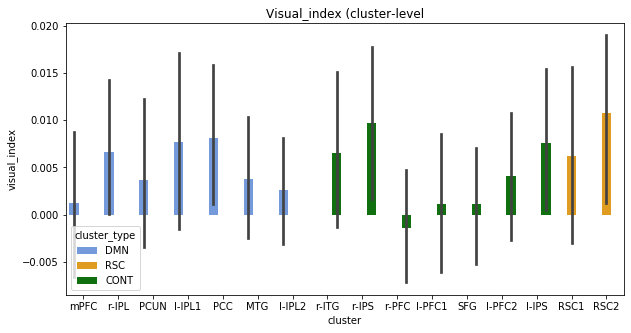

In [56]:
# --------------------
# Cluster level plot 
# --------------------
order = ["mPFC", "r-IPL", "PCUN", "l-IPL1", "PCC", "MTG", "l-IPL2", "r-ITG", "r-IPS", "r-PFC",
                  "l-PFC1", "SFG", 'l-PFC2', "l-IPS", "RSC1", "RSC2"]

fig = plt.figure(figsize = (10, 5))
sns.barplot(x="cluster", y="visual_index", hue='cluster_type', order = order,
            palette=["cornflowerblue", "orange", "green"], data=df_visState).set_title('Visual_index (cluster-level')
plt.show()

In [58]:
df_visState_net = df_visState.groupby(['sub_id', 'cluster_type']).mean().reset_index()
print("----Visual content distinction fc anova-----")
pg.rm_anova(df_visState_net, dv = "visual_index", within = ['cluster_type'], subject="sub_id")

----Visual content distinction fc anova-----


,Source,ddof1,ddof2,F,p-unc,np2,eps
0,cluster_type,2,46,1.418267,0.252522,0.058082,0.927214
